## DOWNLOAD REPOSITORY LENGKAP

In [ ]:
%cd /content/
!git clone https://github.com/irzaip/yolov3 yolov3
%cd /content/yolov3

### DOWNLOAD DATASET DTD (GAMBAR MACAM-MACAM BACKGROUND)

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar xf dtd-r1.0.1.tar.gz

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [165]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random as rnd
import secrets
import imutils

In [166]:
#ukuran gambar yang di create
img_size = 900

In [167]:
kkp = glob.glob('./data_ori/*/k*.png')
tng = glob.glob('./data_ori/*/ten*.png')
tlr = glob.glob('./data_ori/*/tel*.png')

In [168]:
dtd = glob.glob('./dtd/images/*/*.jpg')

In [169]:
len(dtd)

5640

In [170]:
gmb = cv2.imread(kkp[1], cv2.IMREAD_UNCHANGED)
gmb = cv2.cvtColor(gmb, cv2.COLOR_BGRA2RGBA)
gmb_a = gmb[:,:,-1]

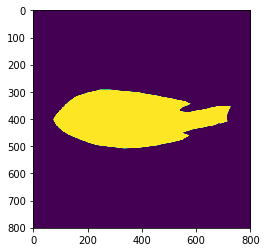

In [171]:
plt.imshow(gmb_a)

#### FUNGSI BANTUAN

untuk menemukan garis kontur dari objek

In [172]:
def find_contour(gmb_a):
    """Mencari kontour dari alpha mask"""
    gmb_a = np.ascontiguousarray(gmb_a, dtype=np.uint8)

    kernel = np.ones((10,10), np.uint8)
    gmb_a = cv2.dilate(gmb_a, kernel , iterations=3)

    _, contours, _ = cv2.findContours(gmb_a, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Approximate contours to polygons + get bounding rects and circles
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])

    drawing = np.zeros((gmb_a.shape[0], gmb_a.shape[1], 3), dtype=np.uint8)

    # Draw polygonal contour + bonding rects + circles
    border = []
    for i in range(len(contours)):
        if boundRect[i][3] != 1:
            border.append(boundRect[i])
        #cv2.drawContours(drawing, contours_poly, i, color)
        cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (100,200,100), 8)
        #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
    
    #print('rec',(int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])))
    border=border[0]
    #print('border:',border)
    x = border[2] // 2 + border[0]
    y = border[3] // 2 + border[1]

    drawing = cv2.circle(drawing, (x,y), 5, (100,200,100),5)
    
    return drawing, (x,y,border[2],border[3])

(401, 402, 681, 244)


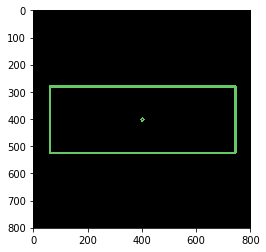

In [173]:
a, d = find_contour(gmb_a)
plt.imshow(a)
print(d)

In [174]:
def flip(img):
    if bool(rnd.getrandbits(1)):
        img = cv2.flip(img,1)
    return img

def imresize(img,x,y):
    img = cv2.resize(img,(x,y))
    return img

def im_rotate(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def imrotate(image, angle):
    image = imutils.rotate(image, angle)
    return image

def immove(img, x, y):
    a = img
    M = np.float32([[1,0,x],[0,1,y]])
    a = cv2.warpAffine(a,M,(a.shape[0],a.shape[1]))
    return a

def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [231]:
def generate(imlist, dtd):
            
        szw = float("{0:.2f}".format(rnd.uniform(0.8,1.2)))
        szh = float("{0:.2f}".format(rnd.uniform(0.8,1.2)))
        top = cv2.imread(secrets.choice(imlist), cv2.IMREAD_UNCHANGED)
        top = cv2.cvtColor(top, cv2.COLOR_BGRA2RGBA)
        height, width, depth = top.shape
        hi = int(height * szh)
        wi = int(width * szw)
        top = imresize(top, hi, wi)
        top = flip(top)
        top_a = top[:,:,-1]
        
       
        bottom = cv2.imread(secrets.choice(dtd))
        bottom = cv2.cvtColor(bottom, cv2.COLOR_BGR2RGB)
        bottom = imresize(bottom, img_size, img_size)
        
        rotd = rnd.randint(0,180)

        top = imrotate(top, rotd)
        top_a = imrotate(top_a, rotd)
        
        blank = np.zeros((bottom.shape[0], bottom.shape[1], 3), dtype=np.uint8)
        dd = np.ones(top.shape)*255
        
        #x1 = rnd.randint(0,50)
        #y1 = rnd.randint(0,50)
        x1 = y1 = 0
        
        rslt = overlay_transparent(bottom, top, x1, y1)

        
        cont, cord = find_contour(top_a)
        mask = overlay_transparent(blank, cont, x1, y1)

        return rslt, mask , cord
    
    
def grcreate(gmbr, dir='./dataval/', prefix='file-', img_class="0", flip=False):
    """
    Membuat database dari sebuah gambar dengan alpha, taruh direktori di dir
    dir: lokasi penyimpanan
    prefix: menambahkan prefix pada file.
    """
    for rotd in range(0,360):

        top = cv2.imread(gmbr, cv2.IMREAD_UNCHANGED)
        top = cv2.cvtColor(top, cv2.COLOR_BGRA2RGBA)
        
        if flip:
            top = cv2.flip(top, 0)
            
        height, width, depth = top.shape
        top_a = top[:,:,-1]
        
        bottom = np.ones((img_size,img_size,3)) * 255
        
        
        top = imrotate(top, rotd)
        top_a = imrotate(top_a, rotd)
        
        x1 = y1 = 0
        
        rslt = overlay_transparent(bottom, top, x1, y1)

        blank = np.zeros((img_size, img_size, 3), dtype=np.uint8)        
        cont, cord = find_contour(top_a)
        mask = overlay_transparent(blank, cont, x1, y1)
        
        pic = rslt

        #print('cord:',cord)
        fld = dir + prefix + "{0:06d}".format(rotd) + '.jpg'

        dd = lambda x: f"".join(img_class)+ " " + str(x[0] / img_size) + " " + str(x[1] / img_size) + " " + \
            str(x[2] / img_size) + " " + str(x[3] / img_size)
            
        pic = np.ascontiguousarray(pic, dtype=np.uint8)
        pic = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
        cv2.imwrite(fld, pic)

        fln = dir + prefix + "{0:06d}".format(rotd) + '.txt'

        with open(fln,'w') as f:
            f.write(dd(cord))
            
        plt.imshow(pic)

In [226]:
def check(file):
  rd = cv2.imread(file+".jpg",cv2.IMREAD_UNCHANGED)
  rd = cv2.cvtColor(rd, cv2.COLOR_BGR2RGB)
  
  with open(file+".txt",'r') as f:
    ln = f.readline()
  
  ln = ln.split(" ")
  crd = (int(float(ln[1]) * img_size), int(float(ln[2]) * img_size), int(float(ln[3]) * img_size), int(float(ln[4]) * img_size))
  print(crd)
  
  
  crd = ((crd[0] - (crd[2] // 2)), (crd[1] - (crd[3] // 2)) , (crd[0] + (crd[2] // 2)), (crd[1] + (crd[3] // 2)))
  print(crd)

  rd = cv2.rectangle(rd,(crd[0], crd[1]), (crd[2], crd[3]), (200,200,2), 4)
  
  plt.imshow(rd)

### testing generate

In [182]:
rr, mm , crd = generate(tng,dtd)
print(crd)

(378, 365, 254, 646)


In [183]:
aa = rr+mm

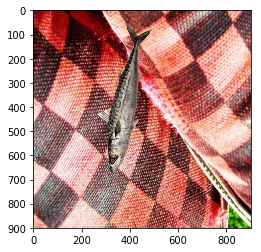

In [184]:
plt.imshow(rr)

## GENERASI BANYAK

In [219]:
def create(data, dtg, start=0, size=100, dir='./dataval/' , prefix='file-', img_class="0"):
    """
    Membuat database dari sebuah gambar dengan alpha, taruh direktori di dir
    dir: lokasi penyimpanan
    prefix: menambahkan prefix pada file.
    """
    for i in range(start,size):
        if i % 100 == 0:
            print('.', end="")
        pic, mm , cord = generate(data,dtg)
        #print('cord:',cord)
        fld = dir + prefix + "{0:06d}".format(i) + '.jpg'

        dd = lambda x: f"".join(img_class)+ " " + str(x[0] / img_size) + " " + str(x[1] / img_size) + " " + \
            str(x[2] / img_size) + " " + str(x[3] / img_size)
            
        pic = cv2.cvtColor(pic, cv2.COLOR_RGB2BGR)
        cv2.imwrite(fld, pic)

        fln = dir + prefix + "{0:06d}".format(i) + '.txt'

        with open(fln,'w') as f:
            f.write(dd(cord))
            
        plt.imshow(mm)

## FUNGSI BIKIN LIST

In [ ]:
def buildlist(dir='./dataval'):
    flist = glob.glob(dir + '/*.jpg')
    flist.sort()
    for idx, i in enumerate(flist):
        fn = i.replace('\\','/')
        flist[idx] = fn
    
    with open(dir + '.txt','w') as f:
        for i in flist:
            f.write(i+'\n')

## GENERATE DATASET

In [ ]:
!rm ./datatrain/*
!rm ./dataval/*

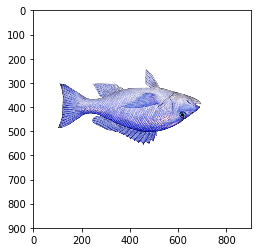

In [232]:
#create(kkp,dtd,start=0, size=1,dir='./datatrain/', prefix='ikan-', img_class="0")
#create(tng,dtd,start=10000, size=10000,dir='./datatrain/', prefix='ikan-', img_class="0")
grcreate('.//data_ori/ps/kakap1.png',dir='./datatrain/',prefix='kkp1-')
grcreate('.//data_ori/ps/kakap1.png',dir='./datatrain/',prefix='kkp1f-', flip=True)
buildlist('./datatrain')

In [ ]:
check('./datatrain/ikan-000000')

In [ ]:
create(kkp,dtd,start=0,size=200,dir='./dataval/', prefix='ikan-', img_class="0")
create(tng,dtd,start=200,size=200,dir='./dataval/', prefix='ikan-', img_class="0")
buildlist('./dataval')

## SIAPKAN CFG YG COCOK DGN KEBUTUHAN

### if using yolov3-tiny.cfg

- Line 3: set batch=24, this means we will be using 24 images for every training step
- Line 4: set subdivisions=8, the batch will be divided by 8 to decrease GPU VRAM requirements.
- Line 127: set filters=(classes + 5)*3 in our case filters=21
- Line 135: set classes=2, the number of categories we want to detect
- Line 171: set filters=(classes + 5)*3 in our case filters=21
- Line 177: set classes=2, the number of categories we want to detect

### kalau menggunakan yolov3.cfg

- Line 3: set batch=24, this means we will be using 24 images for every training step
- Line 4: set subdivisions=8, the batch will be divided by 8 to decrease GPU VRAM requirements.
- Line 603: set filters=(classes + 5)*3 in our case filters=21
- Line 610: set classes=2, the number of categories we want to detect
- Line 689: set filters=(classes + 5)*3 in our case filters=21
- Line 696: set classes=2, the number of categories we want to detect
- Line 776: set filters=(classes + 5)*3 in our case filters=21
- Line 783: set classes=2, the number of categories we want to detect

## PROSES TRAINING

In [ ]:
#TRAIN UNTUK 1 CLASS (gunakan --resume untuk meneruskan)
!python train.py --cfg cfg/yolov3-1cls.cfg --data data/coco.data

In [ ]:
#PINDAHKAN HASIL KE GDRIVE
!cp /content/yolov3/weights/latest.pt /content/gdrive/"My Drive"/yolov3/latest.pt

## TEST DENGAN DATATEST

In [ ]:
mkdir test
create(kkp,dtd,size=10, dir='./test/', prefix='test-')

In [ ]:
!python detect.py --weight ./weights/latest.pt --cfg ./cfg/yolov3-tiny.cfg --images ./test/ --conf-thres 0.1

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.Image("./dataval/ikan-000099.jpg")

## PLOT CONVERGENCE

In [ ]:
from utils import utils; utils.plot_results()